In [68]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [69]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [70]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [71]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [72]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\bryan\AppData\Local\Temp\ipykernel_21260\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [73]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [74]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [75]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [76]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).all()
most_recent_date

[('2017-08-23',)]

In [77]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Query the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the date one year prior and ensure it is in the correct format
one_year_ago = most_recent_date - pd.Timedelta(days=365)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')
one_year_ago_str

'2016-08-23'

In [78]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp) \
    .filter(Measurement.date >= one_year_ago_str) \
    .order_by(Measurement.date) \
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])
precipitation_df.head()

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


In [79]:
# Sort the dataframe by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date']).dt.date
precipitation_df = precipitation_df.sort_values(by='Date')
precipitation_df

,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02
...,...,...
2225,2017-08-22,0.50
2228,2017-08-23,0.08
2226,2017-08-23,0.00
2227,2017-08-23,0.00


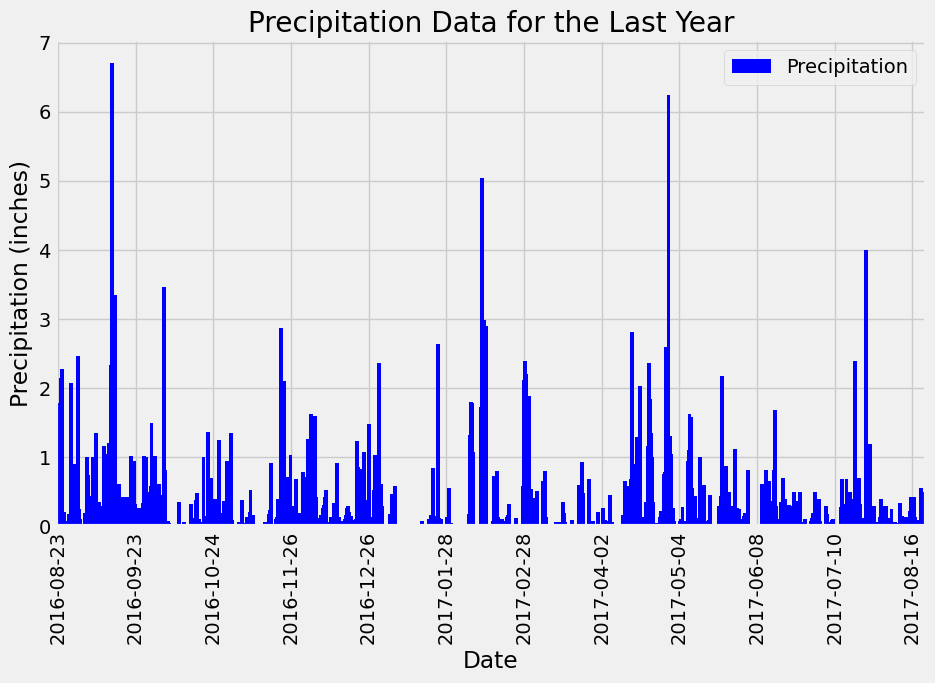

In [80]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(x='Date', y='Precipitation', kind='bar', figsize=(10, 6), color='blue',width=10.0)
plt.title('Precipitation Data for the Last Year')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
# Show only every nth label as too many dates were reflecting, limit the amount of dates displaying in x axis to fit
n = 200
ax.set_xticks(ax.get_xticks()[::n])
plt.show()

In [81]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = precipitation_df['Precipitation'].describe()
print(precipitation_summary)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [82]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [83]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [84]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = 'USC00519281'

temperature_stats = session.query(
    func.min(Measurement.tobs),  
    func.max(Measurement.tobs),  
    func.avg(Measurement.tobs)  
).filter(Measurement.station == station_id).all()

min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Station: {station_id}")
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")

Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


In [85]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
station_id = 'USC00519281'
most_recent_date = session.query(func.max(Measurement.date)).all()[0][0]
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the date from one year ago
one_year_ago = most_recent_date - pd.Timedelta(days=365)

# Display the temperature observations for the yearly period
temperature_data = session.query(Measurement.tobs) \
    .filter(Measurement.station == station_id) \
    .filter(Measurement.date >= one_year_ago.strftime('%Y-%m-%d')) \
    .all()

# Converted the data to a Pandas DataFrame so it can be plotted
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])
temperature_df.head()

,Temperature
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


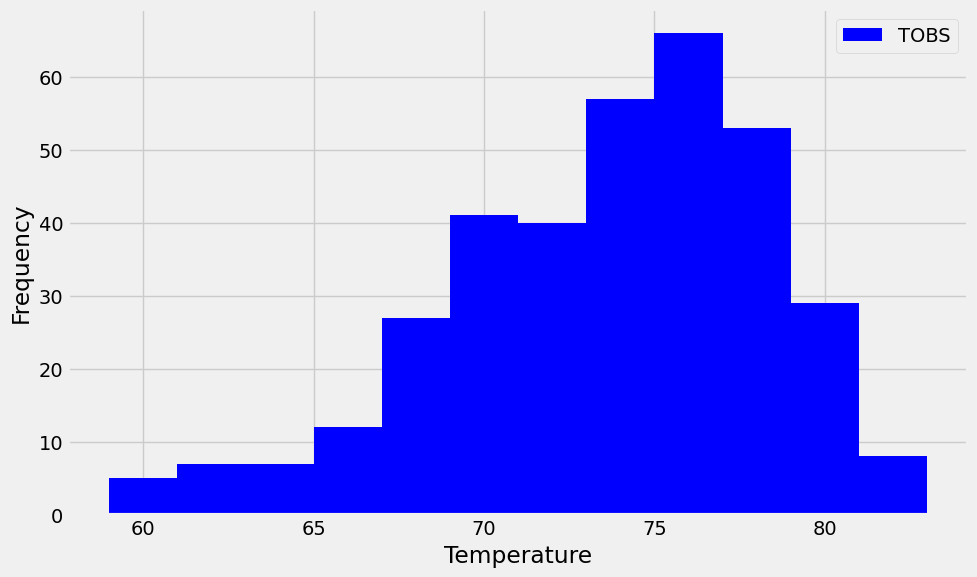

In [86]:
#plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='blue', label='TOBS')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [87]:
# Close Session
session.close()